<a href="https://colab.research.google.com/github/davidjcox333/Man-vs-Machine/blob/master/Nashville_ML_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Packages!!
import os
import sys
import pandas as pd
import numpy as np
import scipy
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, auc
drive.mount('/content/gdrive')
%cd './gdrive/My Drive/Policing Data'
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Policing Data


In [2]:
# Read in the data
nash_raw_data = pd.read_csv("tn_nashville_2020_04_01.csv")
nash_data = nash_raw_data.copy()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,8,15,16,17,22,23,24,25,29,30,31,32,33,35,36,37,38,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data pre-processing

In [3]:
# Sample of what the data looks like and the data types
print(nash_data.dtypes)
nash_data.head()

raw_row_number                     object
date                               object
time                               object
location                           object
lat                               float64
lng                               float64
precinct                           object
reporting_area                    float64
zone                               object
subject_age                       float64
subject_race                       object
subject_sex                        object
officer_id_hash                    object
type                               object
violation                          object
arrest_made                        object
citation_issued                    object
warning_issued                     object
outcome                            object
contraband_found                   object
contraband_drugs                   object
contraband_weapons                 object
frisk_performed                    object
search_conducted                  

,raw_row_number,date,time,location,lat,lng,precinct,reporting_area,zone,subject_age,subject_race,subject_sex,officer_id_hash,type,violation,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,frisk_performed,search_conducted,search_person,search_vehicle,search_basis,reason_for_stop,vehicle_registration_state,notes,raw_verbal_warning_issued,raw_written_warning_issued,raw_traffic_citation_issued,raw_misd_state_citation_issued,raw_suspect_ethnicity,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view
0,232947,2010-10-10,NaN,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...",36.187925,-86.798519,6,4403.0,611,27.0,black,male,80ed1b32eb,vehicular,investigative stop,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,investigative stop,TN,NaN,True,False,False,NaN,N,False,False,False,False,False,False,False
1,237161,2010-10-10,10:00:00,"1122 LEBANON PIKE, NASHVILLE, TN, 37210",36.155521,-86.735902,5,9035.0,513,18.0,white,male,a983204b21,vehicular,moving traffic violation,False,True,False,citation,NaN,NaN,NaN,False,False,False,False,NaN,moving traffic violation,TN,NaN,False,False,True,NaN,N,False,False,False,False,False,False,False
2,232902,2010-10-10,10:00:00,"898 DAVIDSON DR, , TN, 37205",36.117420,-86.895593,1,5005.0,121,52.0,white,male,f5d8fbd78b,vehicular,vehicle equipment violation,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,vehicle equipment violation,TN,NaN,True,False,False,NaN,N,False,False,False,False,False,False,False
3,233219,2010-10-10,22:00:00,"MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...",36.086799,-86.648581,3,8891.0,325,25.0,white,male,4f1d028e45,vehicular,registration,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,registration,TN,NaN,True,False,False,NaN,N,False,False,False,False,False,False,False
4,232780,2010-10-10,01:00:00,"BUCHANAN ST, NORTH, TN, 37208",36.180038,-86.809109,NaN,NaN,NaN,21.0,black,male,0f0e6b7d67,vehicular,vehicle equipment violation,False,False,True,warning,False,False,False,False,True,True,True,probable cause,vehicle equipment violation,TN,NaN,True,False,False,NaN,N,True,True,False,False,False,False,False


In [4]:
# Isolate the columns we're interested in. 
df = nash_data[['date', 'time','location','lat','lng','precinct',\
                'reporting_area','zone','subject_age','subject_race',\
                'subject_sex','officer_id_hash','type','violation',
                'arrest_made','citation_issued','warning_issued',\
                'contraband_found','contraband_drugs',\
                'contraband_weapons','frisk_performed','search_conducted',\
                'search_person','search_vehicle','reason_for_stop',\
                'vehicle_registration_state']]

In [5]:
df.head()

,date,time,location,lat,lng,precinct,reporting_area,zone,subject_age,subject_race,subject_sex,officer_id_hash,type,violation,arrest_made,citation_issued,warning_issued,contraband_found,contraband_drugs,contraband_weapons,frisk_performed,search_conducted,search_person,search_vehicle,reason_for_stop,vehicle_registration_state
0,2010-10-10,NaN,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...",36.187925,-86.798519,6,4403.0,611,27.0,black,male,80ed1b32eb,vehicular,investigative stop,False,False,True,NaN,NaN,NaN,False,False,False,False,investigative stop,TN
1,2010-10-10,10:00:00,"1122 LEBANON PIKE, NASHVILLE, TN, 37210",36.155521,-86.735902,5,9035.0,513,18.0,white,male,a983204b21,vehicular,moving traffic violation,False,True,False,NaN,NaN,NaN,False,False,False,False,moving traffic violation,TN
2,2010-10-10,10:00:00,"898 DAVIDSON DR, , TN, 37205",36.117420,-86.895593,1,5005.0,121,52.0,white,male,f5d8fbd78b,vehicular,vehicle equipment violation,False,False,True,NaN,NaN,NaN,False,False,False,False,vehicle equipment violation,TN
3,2010-10-10,22:00:00,"MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...",36.086799,-86.648581,3,8891.0,325,25.0,white,male,4f1d028e45,vehicular,registration,False,False,True,NaN,NaN,NaN,False,False,False,False,registration,TN
4,2010-10-10,01:00:00,"BUCHANAN ST, NORTH, TN, 37208",36.180038,-86.809109,NaN,NaN,NaN,21.0,black,male,0f0e6b7d67,vehicular,vehicle equipment violation,False,False,True,False,False,False,False,True,True,True,vehicle equipment violation,TN


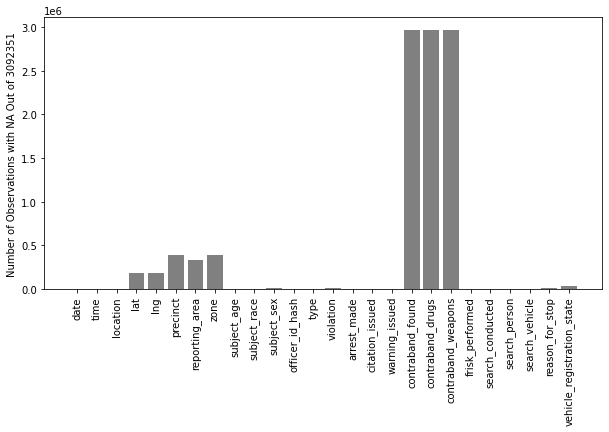

In [6]:
# Count the number of nan per feature. 
data_cols = list(df)
col_nan = []
for i in data_cols:
    val = df[i].isna().sum()
    col_nan.append(val)

# Plot the number of nan per feature
height = col_nan
bars = list(df)
y_pos = np.arange(len(bars))

f, ax = plt.subplots(figsize=(10, 5))
plt.bar(y_pos, height, color='grey')
plt.xticks(y_pos, bars, rotation=90) # Rotation of the bars names
plt.ylabel("Number of Observations with NA Out of %s" %len(df))
plt.show() # Show graphic

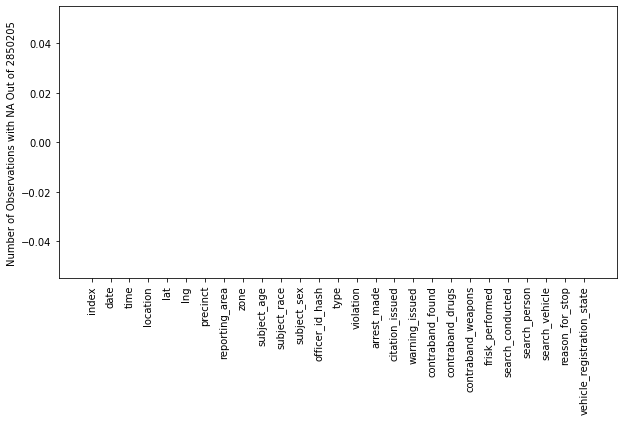

In [7]:
# Manage NaN values by different column data type
import warnings
warnings.simplefilter('ignore')

df['contraband_found'] = df['contraband_found'].fillna(0) # Keep as 0
df['contraband_drugs'] = df['contraband_drugs'].fillna(0) # Keep as 0
df['contraband_weapons'] = df['contraband_weapons'].fillna(0) # Keep as 0
df['zone'] = df['zone'].fillna(999) # Keep as unique category
df['precinct'] = df['precinct'].fillna(999) # Keep as unique category
df['reporting_area'] = df['reporting_area'].fillna(999) # Keep as unique category
df = df.dropna() # Drop remaining rows with NaN
df = df.reset_index()

# Show that all are zero now
data_cols = list(df)
col_nan = []
for i in data_cols:
    val = df[i].isna().sum()
    col_nan.append(val)

# Plot the number of nan per feature
height = col_nan
bars = list(df)
y_pos = np.arange(len(bars))

f, ax = plt.subplots(figsize=(10, 5))
plt.bar(y_pos, height, color='grey')
plt.xticks(y_pos, bars, rotation=90) # Rotation of the bars names
plt.ylabel("Number of Observations with NA Out of %s" %len(df))
plt.show() # Show graphic

In [8]:
# Recode categorical variables as numerical
cat_cols = ['location', 'precinct', 'zone', 'subject_race', 'subject_sex', \
            'officer_id_hash', 'type', 'violation', 'reason_for_stop', \
            'vehicle_registration_state']

for i in cat_cols:
  df[i] = df[i].astype('category')
  df[i] = df[i].cat.codes

In [9]:
# Convert date column to separate numerical month and year columns
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [10]:
# Convert time column to numerical value
import datetime
df['time'] = df['time'].astype(str)

seconds = []

def get_sec(time_str):
  h, m, s = time_str.split(':')
  return (int(h)*3600) + (int(m)*60) + int(s)

for i in list(range(len(df))):
  val = get_sec(df['time'][i])
  seconds.append(val)

df['seconds'] = seconds
df['hour'] = df['seconds']/3600

In [12]:
# Drop date and time columns
df= df.drop(['index', 'date', 'time', 'seconds'], axis=1)

In [13]:
# Turn all true/false columns into 1s and 0s
binary_cols = ['arrest_made', 'citation_issued', 'warning_issued', \
               'contraband_found', 'contraband_drugs', 'contraband_weapons', \
               'frisk_performed', 'search_conducted', 'search_person', \
               'search_vehicle']

for i in binary_cols:
  df[i] = df[i].replace(True, 1)
  df[i] = df[i].replace(False, 0)

In [14]:
# Check data types - should all be ints
print(df.dtypes)

location                        int32
lat                           float64
lng                           float64
precinct                         int8
reporting_area                float64
zone                            int16
subject_age                   float64
subject_race                     int8
subject_sex                      int8
officer_id_hash                 int16
type                             int8
violation                        int8
arrest_made                     int64
citation_issued                 int64
warning_issued                  int64
contraband_found                int64
contraband_drugs                int64
contraband_weapons              int64
frisk_performed                 int64
search_conducted                int64
search_person                   int64
search_vehicle                  int64
reason_for_stop                  int8
vehicle_registration_state       int8
year                            int64
month                           int64
hour        

In [15]:
# Save df for future analyses
df.to_csv('nash_data_for_ml.csv')

# Create feature and outcome dfs; scale features

In [3]:
# If starting fresh here, load data
data = pd.read_csv('nash_data_for_ml.csv')
df = data.copy()
df = df.drop(['Unnamed: 0'], axis=1)

In [4]:
# Create dataframes
targets = ['arrest_made','citation_issued','warning_issued','contraband_found',\
            'contraband_drugs','contraband_weapons','frisk_performed',\
            'search_conducted','search_person','search_vehicle']
features = df.drop(targets, axis=1)
outcomes = df.loc[:, targets].values
outcomes = pd.DataFrame(outcomes)
outcomes.columns = targets

In [5]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler
feats_rescaled = MinMaxScaler().fit_transform(features)

# Label columns of rescaled features
feats_rescaled = pd.DataFrame(feats_rescaled)
feat_cols = list(features)
feats_rescaled.columns = feat_cols

# Machine Learning Classification Predictions

In [6]:
# Packages we'll be using
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [7]:
# Define functions
def bin_metrics(x, y):
    '''Prints four common metrics for evaluating classification predictions.'''
    print('Accuracy:', round(metrics.accuracy_score(x, y), 4))
    print('Precision:', round(metrics.precision_score(x, y, average='weighted'), 4))
    print('Recall:', round(metrics.recall_score(x, y, average='weighted'), 4))
    print('F1:', round(metrics.f1_score(x, y, average='weighted'), 4))

def plot_cm(x, y, title):
    '''Plots a confusion matrix.'''
    plt.subplots(figsize=(6, 5))
    cm = confusion_matrix(x, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(x), index = np.unique(x))
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20}, fmt='g')# font size
    plt.ylim([0, 2])
    plt.title(title, fontsize=20)
    plt.xlabel('Predicted', fontsize=30)
    plt.ylabel('Observed', fontsize=30)
    print("\n")

In [10]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

def log_reg(outcome_variable):
  X_train, X_test, y_train, y_test = train_test_split(feats_rescaled, outcome_variable, test_size=0.20, random_state = 8675309)
  classifier = LogisticRegression(solver='liblinear')
  classifier.fit(X_train, y_train)
  feat_weights = classifier.coef_
  y_pred = classifier.predict(X_test)
  return y_test, y_pred, feat_weights

Citations Issued:
Accuracy: 0.7856
Precision: 0.7377
Recall: 0.7856
F1: 0.7003




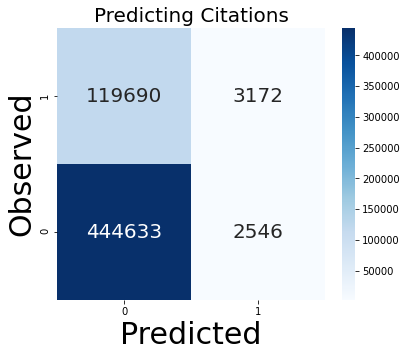

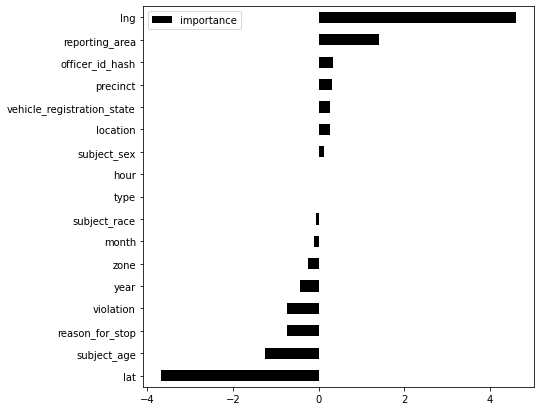

In [35]:
# Predicting citations
print("Citations Issued:")
cites_test, cites_pred, cites_weights = log_reg(outcomes['citation_issued'])
bin_metrics(cites_test, cites_pred)
plot_cm(cites_test, cites_pred, 'Predicting Citations')
cites_weights = cites_weights[0]
feature_importances = pd.DataFrame(cites_weights, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

In [ ]:
# Predicting Frisks
print("\n\nFrisks:")
frisk_test, frisk_pred, frisk_weights = log_reg(outcomes['frisk_performed'])
print(frisk_weights)
bin_metrics(frisk_test, frisk_pred)
plot_cm(frisk_test, frisk_pred, 'Predicting Frisks')
cites_weights = cites_weights[0]
feature_importances = pd.DataFrame(cites_weights, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

In [ ]:
# Predicting Searches
print("\n\nSearches:")
search_test, search_pred, search_weights = log_reg(outcomes['search_conducted'])
print(search_weights)
bin_metrics(search_test, search_pred)
plot_cm(search_test, search_pred, 'Predicting Searches')
cites_weights = cites_weights[0]
feature_importances = pd.DataFrame(cites_weights, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

In [ ]:
# Predicting Contraband Found
print("\n\nContraband Found:")
contra_test, contra_pred, contra_weights = log_reg(outcomes['contraband_found'])
print(contra_weights)
bin_metrics(contra_test, contra_pred)
plot_cm(contra_test, contra_pred, 'Predicting Contraband Found')
cites_weights = cites_weights[0]
feature_importances = pd.DataFrame(cites_weights, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

def rand_for(outcome_variable):
  acc_scores = []
  prec_scores = []
  recall_scores = []
  f1_scores = []
  nEst_range = [10, 50, 100, 1000]
  depth_range = [2, 5, 10, 100]
  for i in nEst_range:
      for k in depth_range:
          X_train, X_test, y_train, y_test = train_test_split(feats_rescaled, outcome_variable, test_size=0.20, random_state = 649)
          classifier = RandomForestClassifier(n_estimators=i, max_depth=k)
          classifier.fit(X_train, y_train)
          pred_train= classifier.predict(X_train)
          pred_test= classifier.predict(X_test)
          acc_val = metrics.accuracy_score(y_test, pred_test)
          acc_scores.append(acc_val)
          prec_val = metrics.precision_score(y_test, pred_test, average='weighted')
          prec_scores.append(prec_val)
          recall_val = metrics.recall_score(y_test, pred_test, average='weighted')
          recall_scores.append(recall_val)
          f1_val = f1_score(y_test, pred_test)
          f1_scores.append(f1_val)
  plt.plot(acc_scores, marker='o', color='black')
  plt.plot(f1_scores, marker='o', color='blue')
  print("Max Accuracy:", round(max(acc_scores), 2))
  print('Max Precision:', round(max(prec_scores), 4))
  print('Max Recall:', round(max(recall_scores), 4))
  print('Max F1:', round(max(f1_scores), 2))

Citations Issued:



In [ ]:
# Predicting citations
print("Citations Issued:\n")
rand_for(outcomes['citation_issued'])

In [ ]:
# Predicting Frisks
print("Frisks:\n")
rand_for(outcomes['frisk_performed'])

In [ ]:
# Predicting Searches
print("Searches:\n")
rand_for(outcomes['search_conducted'])

In [ ]:
# Predicting Contraband Found
print("Contraband Found:\n")
rand_for(outcomes['contraband_found'])

In [ ]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier

def adaboost(outcome_varaible):
  X_train, X_test, y_train, y_test = train_test_split(feats_rescaled, mathOutc, test_size=0.20, random_state = 0)
  acc_scores = []
  prec_scores = []
  recall_scores = []
  f1_scores = []
  nEst_range = [10, 50, 100, 1000]
  learning_rate_range = [0.01, 1, 10]
  for i in nEst_range:
      for k in learning_rate_range:
          classifier = AdaBoostClassifier(n_estimators=i, learning_rate=k)
          classifier.fit(X_train, y_train)
          pred_train= classifier.predict(X_train)
          pred_test= classifier.predict(X_test)
          acc_val = metrics.accuracy_score(y_test, pred_test)
          acc_scores.append(acc_val)
          f1_val = f1_score(y_test, pred_test)
          f1_scores.append(f1_val)
  plt.plot(acc_scores, marker='o', color='black')
  plt.plot(f1_scores, marker='o', color='blue')
  print("Max Accuracy:", round(max(acc_scores), 2))
  print('Max Precision:', round(max(prec_scores), 4))
  print('Max Recall:', round(max(recall_scores), 4))
  print('Max F1:', round(max(f1_scores), 2))

# Predicting citations
print("Citations Issued:\n")
adaboost(outcomes['citation_issued'])

# Predicting Frisks
print("Frisks:\n")
adaboost(outcomes['frisk_performed'])

# Predicting Searches
print("Searches:\n")
adaboost(outcomes['search_conducted'])

# Predicting Contraband Found
print("Contraband Found:\n")
adaboost(outcomes['contraband_found'])

In [ ]:
# Multilayer Perceptron
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(feats_rescaled, mathOutc, test_size=0.20, random_state = 0)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)
acc_scores = []
f1_scores = []
nEst_range = [10, 50, 100, 1000]
learning_rate_range = [0.01, 1, 10]
for i in nEst_range:
    for k in learning_rate_range:
        classifier = MLPClassifier(max_iter = 500)
        classifier.fit(train_scaled, y_train)
        pred_train= classifier.predict(X_train)
        pred_test= classifier.predict(test_scaled)
        acc_val = metrics.accuracy_score(y_test, pred_test)
        acc_scores.append(acc_val)
        f1_val = f1_score(y_test, pred_test)
        f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
print("Max Accuracy:", round(max(acc_scores), 2))
print('Max F1:', round(max(f1_scores), 2))